# Kickstarter Projects
# Day 3 Homework for a Machine Learning Course
Author：Hiroki Miyamoto

Data : Kickstarter Projects https://www.kaggle.com/kemical/kickstarter-projects

## Objective of Day 3 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 3.

### Table of Contents (Day 3)
1. Data Preparation and visualization
1. Feature Selection (Embedded Lasso)
1. Logistic Regression (Elastic Net)
1. Desicion Tree
1. Random Forest
1. Adaboost
1. Neural Network

# Summary

The best score was Adaboost but it required the most CPU time for grid search.

| Model | Test Score   |  CPU Time for Grid Search |
|------|------|------|
|   Logistic Regression (Elastic Net)  | 0.675 | 2h 26min 48s |
|   Desicion Tree  | 0.659 | 10min 46s |
|   Random Forest  | 0.678 | 8h 5min 36s |
|   Adaboost  | 0.684 | 19h 36min 4s |
|   Neural Network  | 0.679 | 10h 11min 48s |

- Objective variable
    - state (successful = 1, failed = 0)
        - 'canceled', 'undefined', 'live' and 'suspended' are dropped off from the data to develop a discriminator which can discriminate only whether a Kickstarter is successful or failed.
- Explanatory variables
    - category
        - Used as dummy variables.
    - currency
        - Used as dummy variables.
    - usd_goal_real_log10
        - Log scale of usd_goal_real.
    - time_campaign
        - Created from launched and deadline.
    - name_words
        - Created from name.
    - name_exclaim_question
        - Created from name.

        


# Links to my homeworks
- GitHub
    - https://github.com/hmiyamoto1/skillupai_ml
- Kaggle (same notebooks uploaded on GitHub)
    - Day1
        - Objective of Day 1 : Build a supervised machine learning model based on the lecture on Day 1. Don't care about the accuracy for now.
        - https://www.kaggle.com/hmiyamoto/day-1-homework-for-a-machine-learning-course/
    - Day2
        - Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-for-a-machine-learning-course/
    - Day2 Appendix-1
        - Check the contribution of explanatory variables for prediction by investigating the weight
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-1
    - Day2 Appendix-2
        - Check the contribution of explanatory variables for prediction by investigating the weight again
            - "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-2

# 1. Data Preparation and visualization

## Import

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

# machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# neural network
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier


/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


## Acquire data

In [2]:
df_kick = pd.read_csv("../input/ks-projects-201801.csv")

## Preview the data

In [3]:
display(df_kick.head())
display(df_kick.describe())
display(df_kick.describe(include=['O']))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


## Arrange state data

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


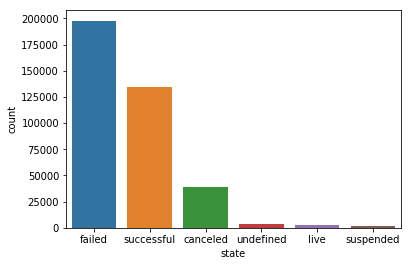

In [4]:
print(df_kick['state'].value_counts(dropna=False))
g = sns.countplot(df_kick['state'],
                 order = df_kick['state'].value_counts().index)

The problem is to predict whether cloud fundings will succeed or not. Therefore, 'canceled', 'undefined', 'live' and 'suspended' are not suitable to use train and test data because these fundings are not known to succeed or fail. So, these variables are dropped off from data.

In [5]:
df_kick.drop(df_kick.index[df_kick.state == 'canceled'], inplace=True)
df_kick.drop(df_kick.index[df_kick.state == 'undefined'], inplace=True)
df_kick.drop(df_kick.index[df_kick.state == 'live'], inplace=True)
df_kick.drop(df_kick.index[df_kick.state == 'suspended'], inplace=True)

failed        197719
successful    133956
Name: state, dtype: int64
failed        0.596123
successful    0.403877
Name: state, dtype: float64


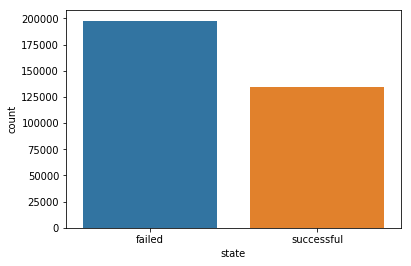

In [6]:
g = sns.countplot(df_kick['state'],
                 order = df_kick['state'].value_counts().index)
print(df_kick['state'].value_counts(dropna=False))
print(df_kick['state'].value_counts(dropna=False, normalize=True))

## Arrange dataframe with selected features

- Numerical features
    - Integer
        - ~~ID~~
            - would not affect successful or not.
        - ~~backers~~
            - would not be suitable for prediction because number of backers is a result of funding.
        - **time_campaign (created feature)**
            - Roughly speaking, the longer time_campaign is, the less successful rate is.
    - Float
        - ~~goal~~
        - ~~pledged~~
        - ~~usd pledged~~
        - ~~usd_pledged_real~~
            - would not be suitable for prediction because pledged money is a result of funding.
        - **usd_goal_real**
            - Successful companies has a strong peak between 10^3 to 10^4 usd_goal_real.
            - Used as log scale.
- Categorical features
    - Strings (object)
        - name
            - **name_words (created feature)**
                - Success rates are different by number of words in the name.
            - **name_exclaim_question (created feature)**
                - Success rates are different by presence of ! or ?.
        - **category**
            - Success rates are different between category.
            - Used as dummy variables.
        - ~~main_category~~
            - Success rates are different between main_category.
            - However, category would be more accurate to explain.
        - **currency**
            - Success rates are different between currency.
            - Used as dummy variables.
        - ~~deadline~~
            - time_campaign would be more accurate to explain.
        - ~~launched~~
            - time_campaign would be more accurate to explain.
        - **state**
            - Objective variable
                - successful = 1, failed = 0
                - 'canceled', 'undefined', 'live' and 'suspended' are dropped off from data to develop a discriminator which can discriminate only whether a Kickstarter is successful or failed.
        - ~~country~~
            - is similar feature with currency.

### Category

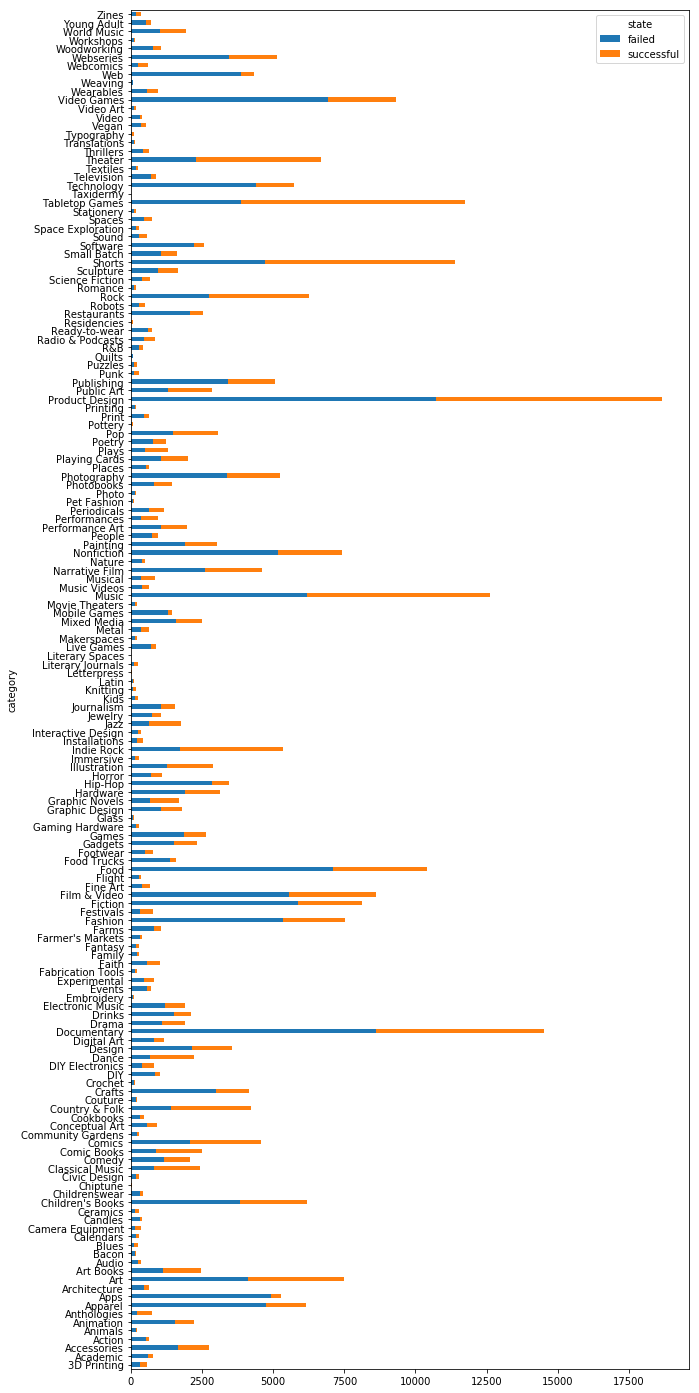

In [7]:
pd.crosstab(df_kick['category'], df_kick['state'])[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25))

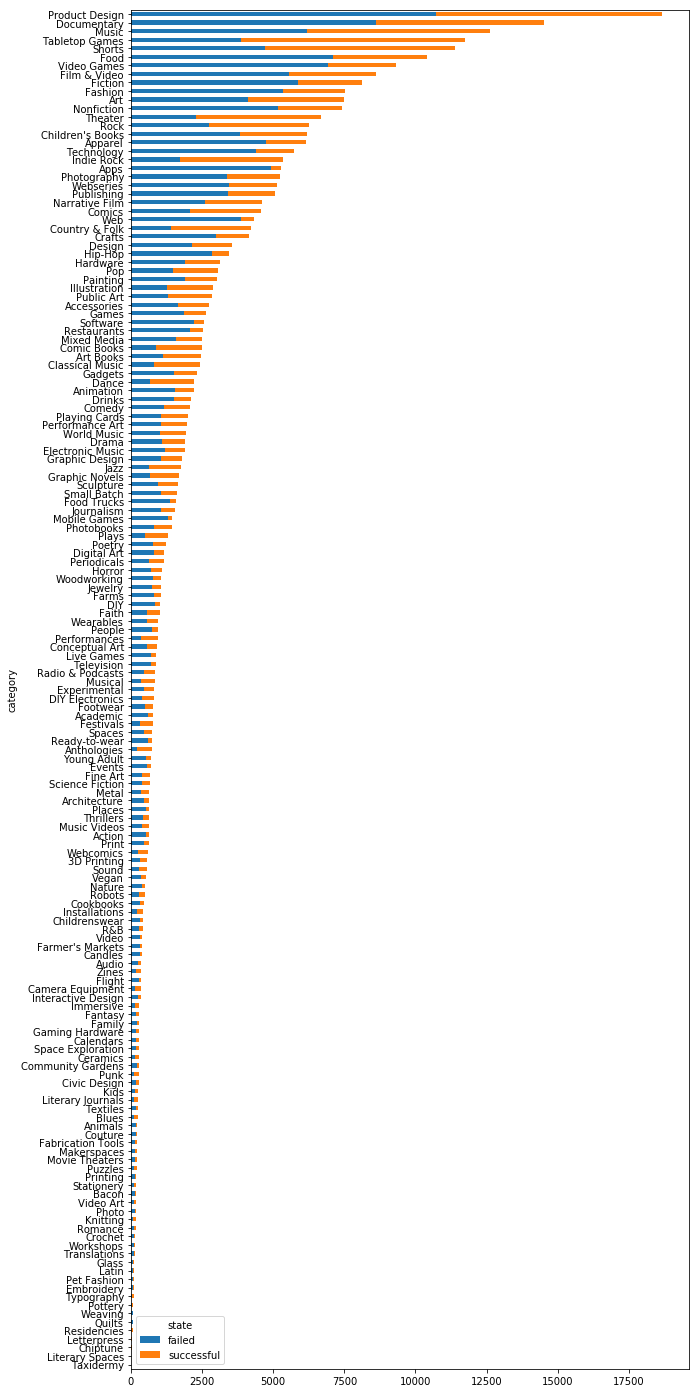

In [8]:
ct = pd.crosstab(df_kick['category'], df_kick['state'])
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

Success rates are different between category. Therefore, category is used as an explanatory variable for model training.

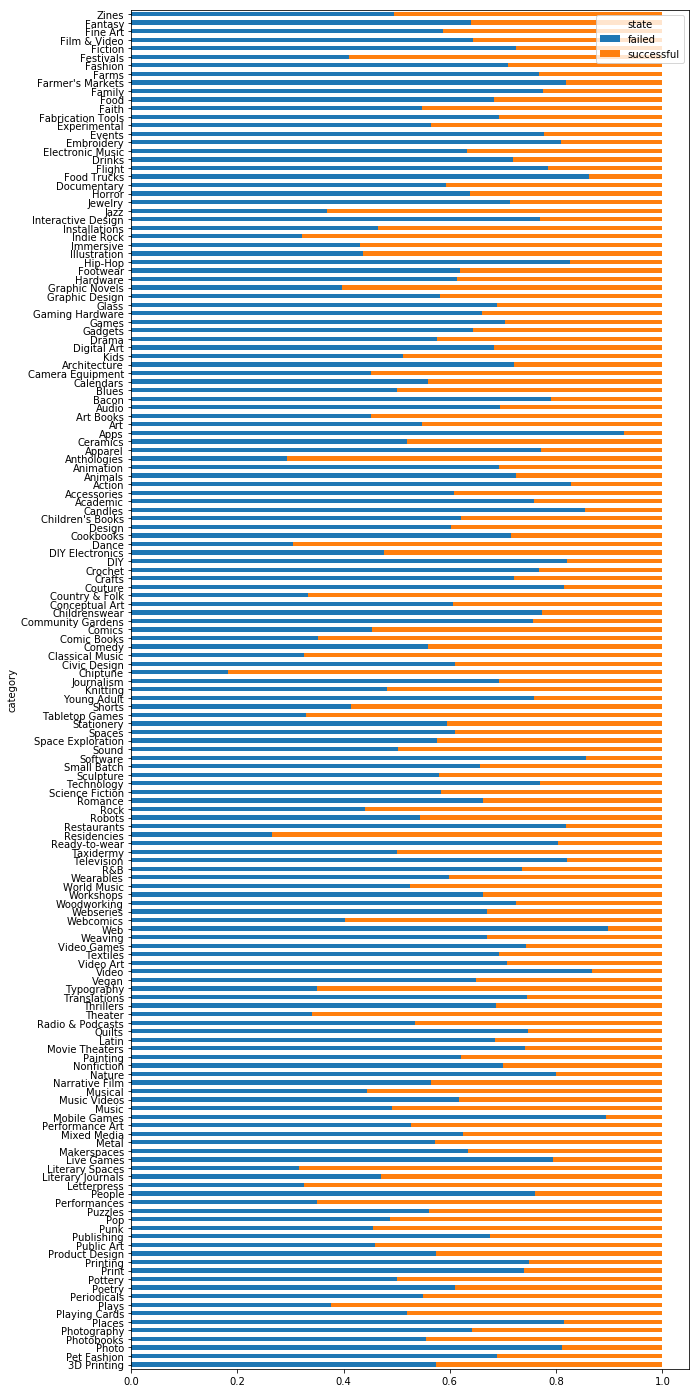

In [9]:
ct = pd.crosstab(df_kick['category'], df_kick['state'], normalize='index')
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

### Currency

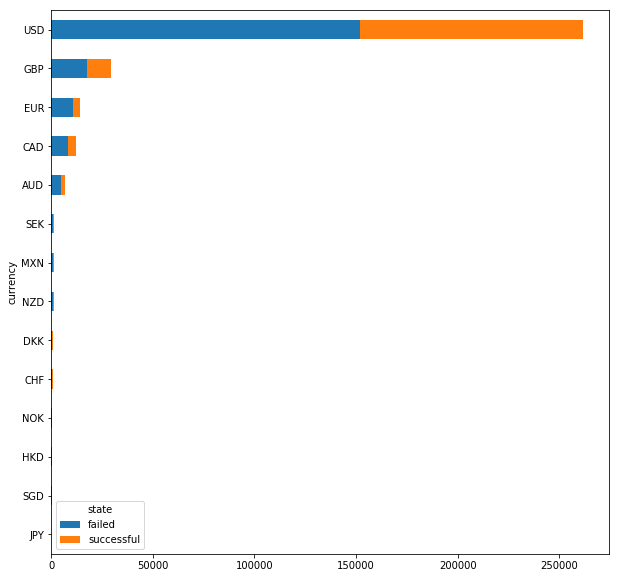

In [10]:
ct = pd.crosstab(df_kick['currency'], df_kick['state'])
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,10));

Success rates are different between currency. Therefore, currency is used as an explanatory variable for model training.

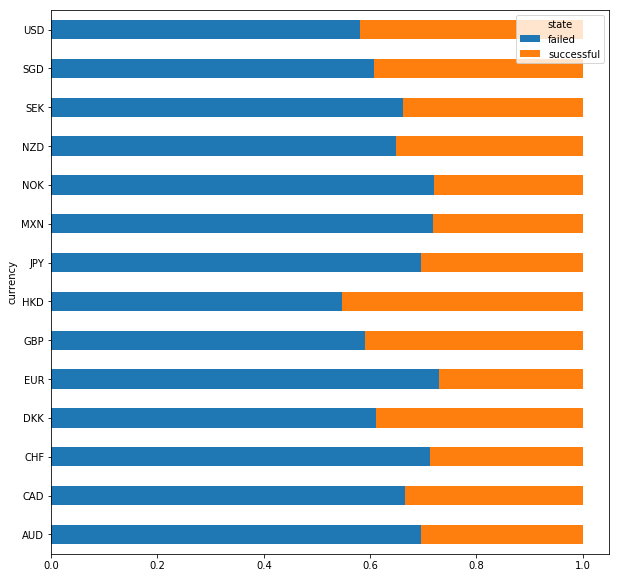

In [11]:
ct = pd.crosstab(df_kick['currency'], df_kick['state'], normalize='index')
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=["sum"], ascending=True)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,10));

### Create usd_goal_real_log10

In [12]:
epsilon = 1
df_kick['usd_goal_real_log10'] = np.log10(df_kick['usd_goal_real'] + epsilon)

Success rates are different by usd_goal_real_log10. Therefore, usd_goal_real_log10 is used as an explanatory variable for model training.

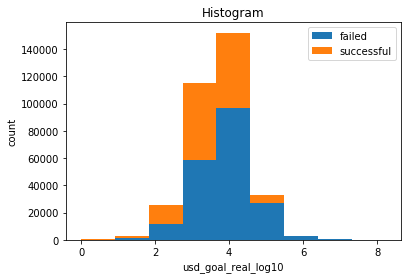

In [13]:
plt.hist((df_kick['usd_goal_real_log10'][df_kick['state']=='failed'],
         df_kick['usd_goal_real_log10'][df_kick['state']=='successful']), bins=9, histtype='barstacked',
        label=('failed', 'successful')) 
plt.xlabel('usd_goal_real_log10')
plt.ylabel('count')
plt.title('Histogram')
plt.legend()
plt.show() 

### Create time_campaign
Referenced from https://www.kaggle.com/kabure/kickstarter-interactive-explanatory-exploration

In [14]:
df_kick['launched'] = pd.to_datetime(df_kick['launched'])
df_kick['laun_day'] = df_kick['launched'].dt.to_period("D")

df_kick['deadline'] = pd.to_datetime(df_kick['deadline'])
df_kick['dead_day'] = df_kick['deadline'].dt.to_period("D")

#Creating a new columns with Campaign total months
df_kick['time_campaign'] = df_kick['dead_day'] - df_kick['laun_day']
df_kick['time_campaign'] = df_kick['time_campaign'].astype(int)

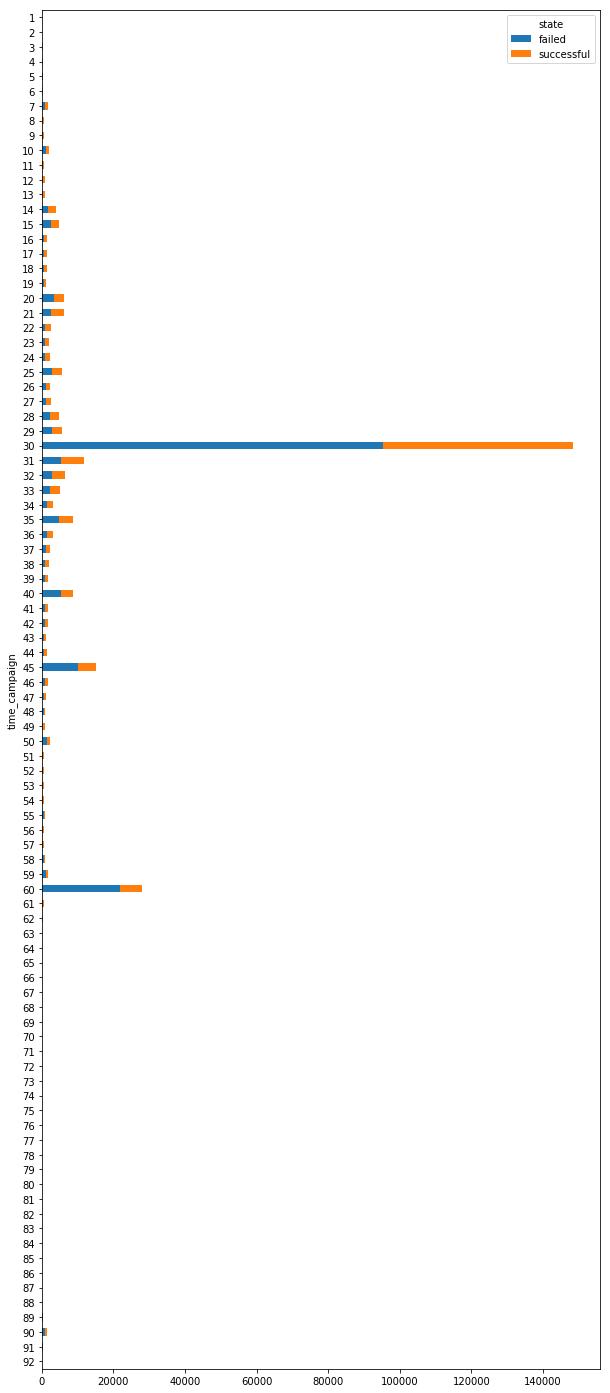

In [15]:
ct = pd.crosstab(df_kick['time_campaign'], df_kick['state'])
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['time_campaign'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

Success rates are different by time_campaign. Therefore, time_campaign is used as an explanatory variable for model training.

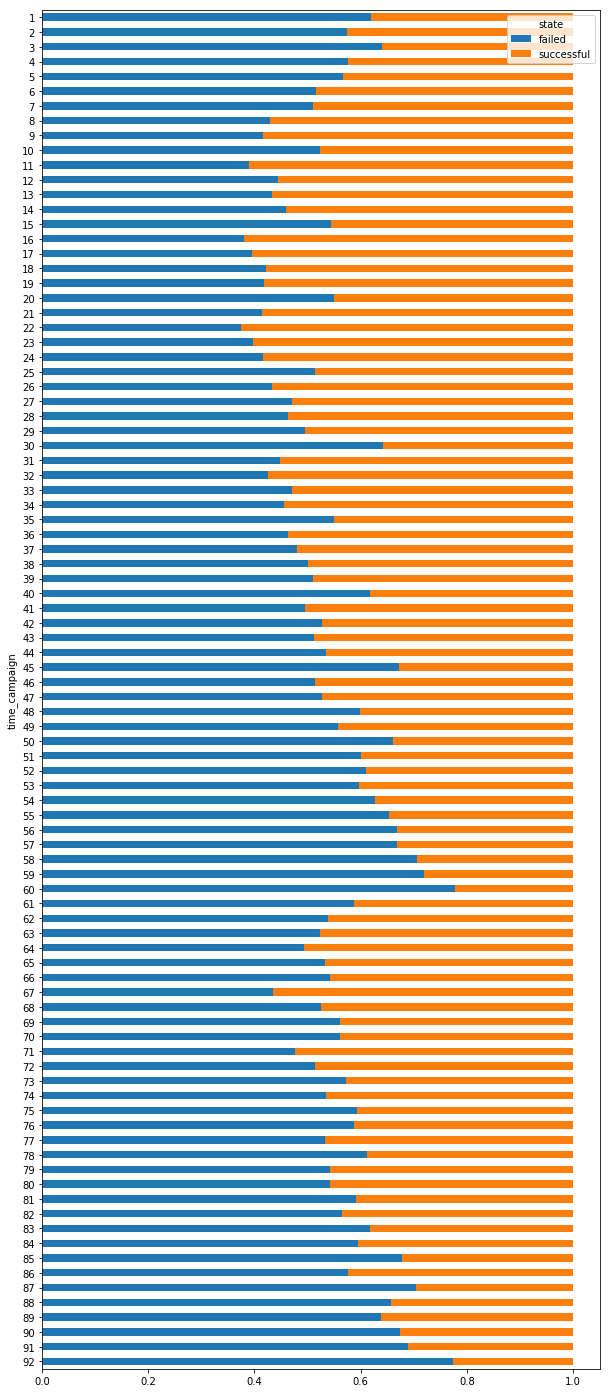

In [16]:
ct = pd.crosstab(df_kick['time_campaign'], df_kick['state'], normalize='index')
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['time_campaign'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

### Create name features
Referenced from https://www.kaggle.com/srishti280992/kickstarter-project-classification-lgbm-70-3

In [17]:
#creating features from the project name

# #length of name
# df_kick['name_len'] = df_kick.name.str.len()

# presence of ! or ?
df_kick['name_exclaim_question'] = (df_kick.name.str[-1] == ('!' or '?')).astype(int)

# # presence of !
# df_kick['name_question'] = (df_kick.name.str[-1] == '?').astype(int)

# number of words in the name
df_kick['name_words'] = df_kick.name.apply(lambda x: len(str(x).split(' ')))

# # if name is uppercase
# df_kick['name_is_upper'] = df_kick.name.str.isupper().astype(float)

name_words : number of words in the name

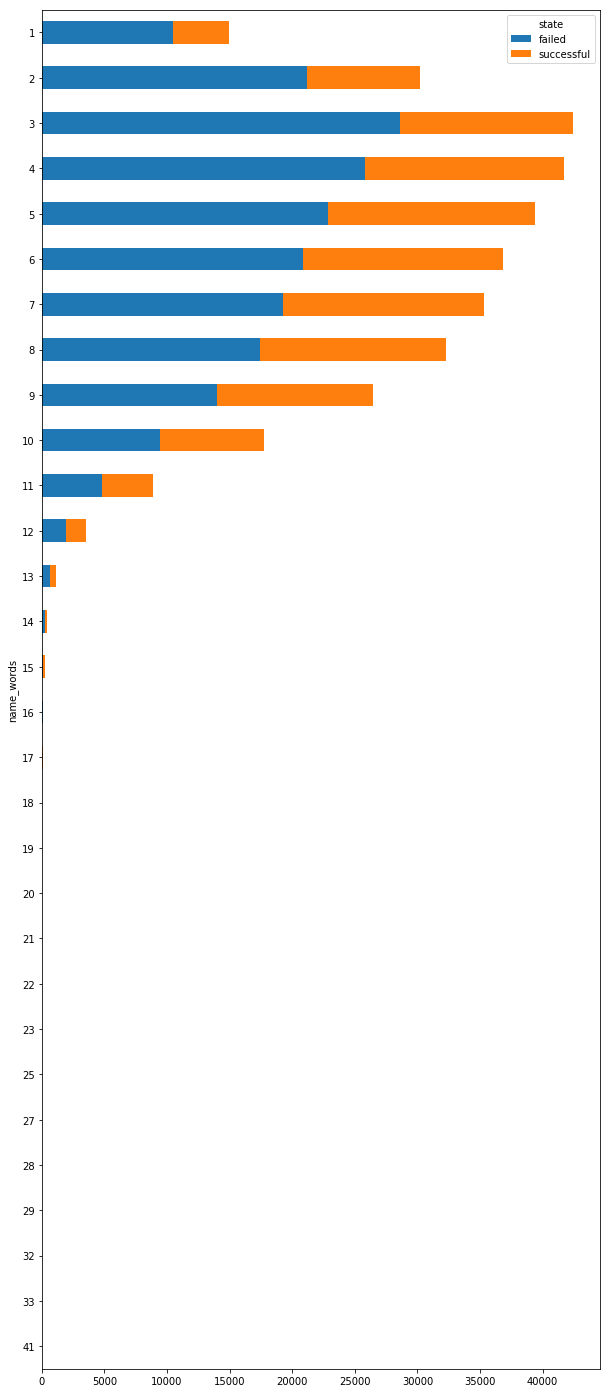

In [18]:
ct = pd.crosstab(df_kick['name_words'], df_kick['state'])
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['name_words'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

Success rates are different by name_words. Therefore, name_words is used as an explanatory variable for model training.

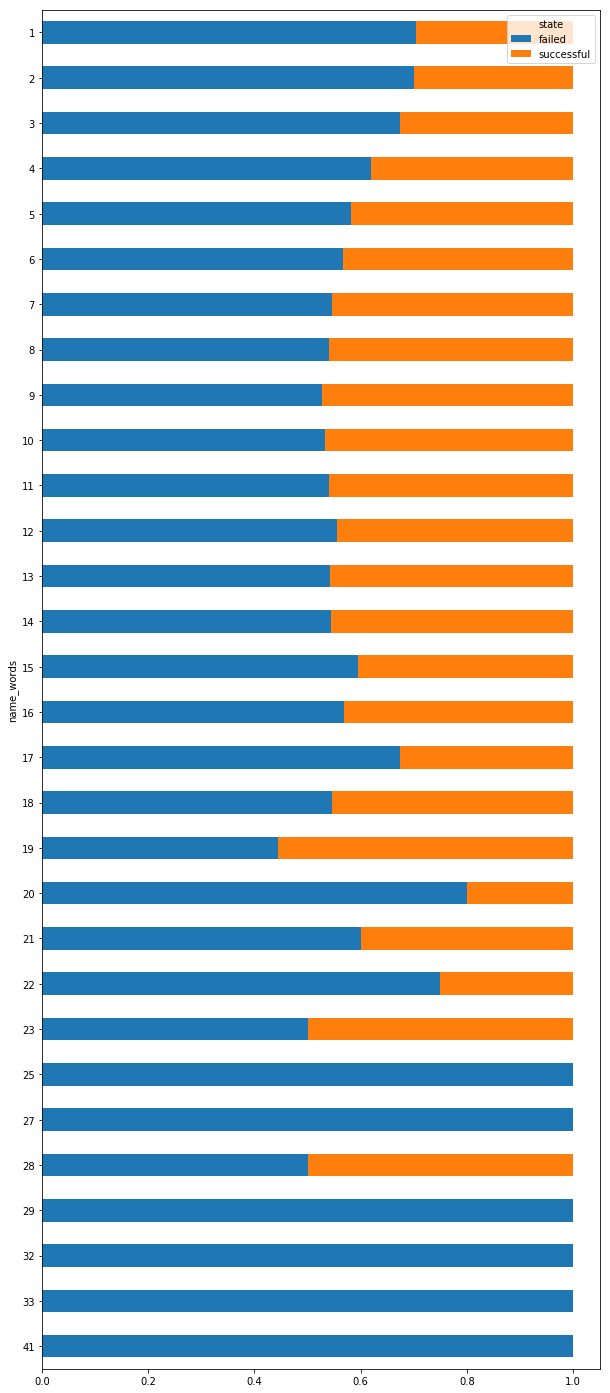

In [19]:
ct = pd.crosstab(df_kick['name_words'], df_kick['state'], normalize='index')
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['name_words'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,25));

name_exclaim_question : presence of ! or ?

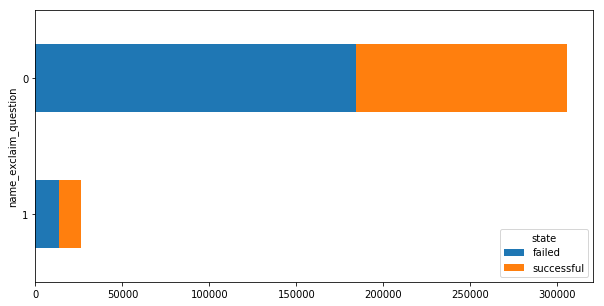

In [20]:
ct = pd.crosstab(df_kick['name_exclaim_question'], df_kick['state'])
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['name_exclaim_question'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,5));

Success rates are different by name_exclaim_question. Therefore, name_exclaim_question is used as an explanatory variable for model training.

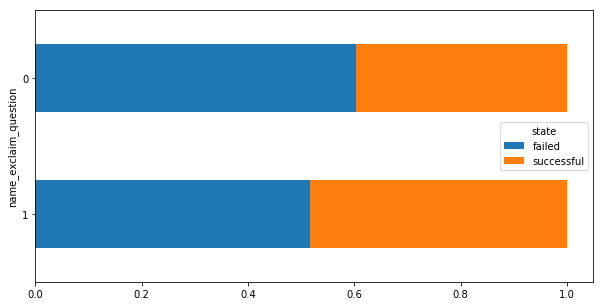

In [21]:
ct = pd.crosstab(df_kick['name_exclaim_question'], df_kick['state'], normalize='index')
ct['sum'] = ct['failed'] + ct['successful']
ct = ct.sort_values(by=['name_exclaim_question'], ascending=False)
ct[['failed','successful']].plot(kind='barh',stacked=True,figsize=(10,5));

### Delete unused features

In [22]:
df_kick.drop(['ID','name','main_category','deadline', 'goal', 'country',
              'launched', 'pledged', 'backers', 'usd pledged','usd_pledged_real',
              'usd_goal_real', 'laun_day', 'dead_day'], axis=1, inplace=True)

### state (successful = 1, failed = 0)

In [23]:
df_kick['state'].loc[df_kick['state'] != 'successful'] = 0
df_kick['state'].loc[df_kick['state'] == 'successful'] = 1

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
display(df_kick.head())
display(df_kick.describe())
display(df_kick.describe(include=['O']))

,category,currency,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words
0,Poetry,GBP,0,3.186094,59,0,6
1,Narrative Film,USD,0,4.477136,60,0,8
2,Narrative Film,USD,0,4.653222,45,0,3
3,Music,USD,0,3.699057,30,0,7
5,Restaurants,USD,1,4.698979,35,0,3


,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,3.727388,33.954875,0.078836,5.654704
std,0.490674,0.724015,12.713332,0.269483,2.784691
min,0.000000,0.004321,1.000000,0.000000,1.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000
max,1.000000,8.221053,92.000000,1.000000,41.000000


,category,currency
count,331675,331675
unique,159,14
top,Product Design,USD
freq,18680,261511


### Convert categorical variables into dummy variables

In [25]:
df_kick = pd.get_dummies(df_kick, columns=['category', 'currency'])

In [26]:
display(df_kick.head())
display(df_kick.describe())
# display(df_kick.describe(include=['O']))

,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,3.186094,59,0,6,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,4.477136,60,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,4.653222,45,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,3.699057,30,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,4.698979,35,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,3.727388,33.954875,0.078836,5.654704,0.001713,0.002343,0.008261,0.001872,0.000690,...,0.043350,0.088870,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788456
std,0.490674,0.724015,12.713332,0.269483,2.784691,0.041347,0.048344,0.090515,0.043230,0.026267,...,0.203643,0.284557,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408404
min,0.000000,0.004321,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,8.221053,92.000000,1.000000,41.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_kick.fillna(df_kick.mode().iloc[0], inplace=True)

## Devide dataframe into train data(trian & validation) and test data(final check)
- df_kick
    - df_TRAIN : 80%
        - This will be further devided into train and validation data in holdout or cross-validation training phase.
            - train : 80%
            - valid : 20%
    - df_TEST : 20%
        - This is blind data for final test.

In [28]:
df_TRAIN, df_TEST = train_test_split(df_kick, test_size=0.2, random_state=1234)
display(df_TRAIN.describe())
display(df_TEST.describe())

,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,...,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000
mean,0.404571,3.726273,33.943299,0.078835,5.651624,0.001752,0.002382,0.008299,0.001881,0.000735,...,0.043627,0.088682,0.001477,0.000060,0.004229,0.001752,0.003806,0.004602,0.001338,0.787876
std,0.490810,0.723414,12.700887,0.269481,2.782060,0.041826,0.048746,0.090719,0.043325,0.027099,...,0.204264,0.284285,0.038408,0.007765,0.064890,0.041826,0.061579,0.067679,0.036553,0.408813
min,0.000000,0.004321,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,8.180114,92.000000,1.000000,41.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,...,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.00000,66335.000000,66335.000000,66335.000000
mean,0.401100,3.731848,34.001176,0.078842,5.667023,0.001553,0.002186,0.008110,0.001839,0.000513,...,0.042240,0.089621,0.001281,0.000106,0.004357,0.001794,0.00398,0.004357,0.001492,0.790774
std,0.490125,0.726398,12.762985,0.269494,2.795174,0.039374,0.046703,0.089692,0.042846,0.022634,...,0.201138,0.285640,0.035774,0.010272,0.065862,0.042317,0.06296,0.065862,0.038603,0.406759
min,0.000000,0.252853,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
max,1.000000,8.221053,92.000000,1.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


# 2. Feature Selection (Embedded Lasso)

In [29]:
%%time
estimator = LassoCV(normalize=True, cv=5, random_state=1234)
sfm = SelectFromModel(estimator, threshold=1e-5)

train_label = df_TRAIN["state"]
train_data = df_TRAIN.drop("state", axis=1)

y = train_label.values
X = train_data.values

stdsc = StandardScaler()
X = stdsc.fit_transform(X)

sfm.fit(X, y)

CPU times: user 55.3 s, sys: 3.48 s, total: 58.7 s
Wall time: 54.1 s


In [30]:
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [31]:
removed_idx  = ~sfm.get_support()
remove_feature = train_data.columns[removed_idx]
remove_feature

Index(['category_Film & Video', 'category_Gaming Hardware', 'category_Metal',
       'currency_CHF'],
      dtype='object')

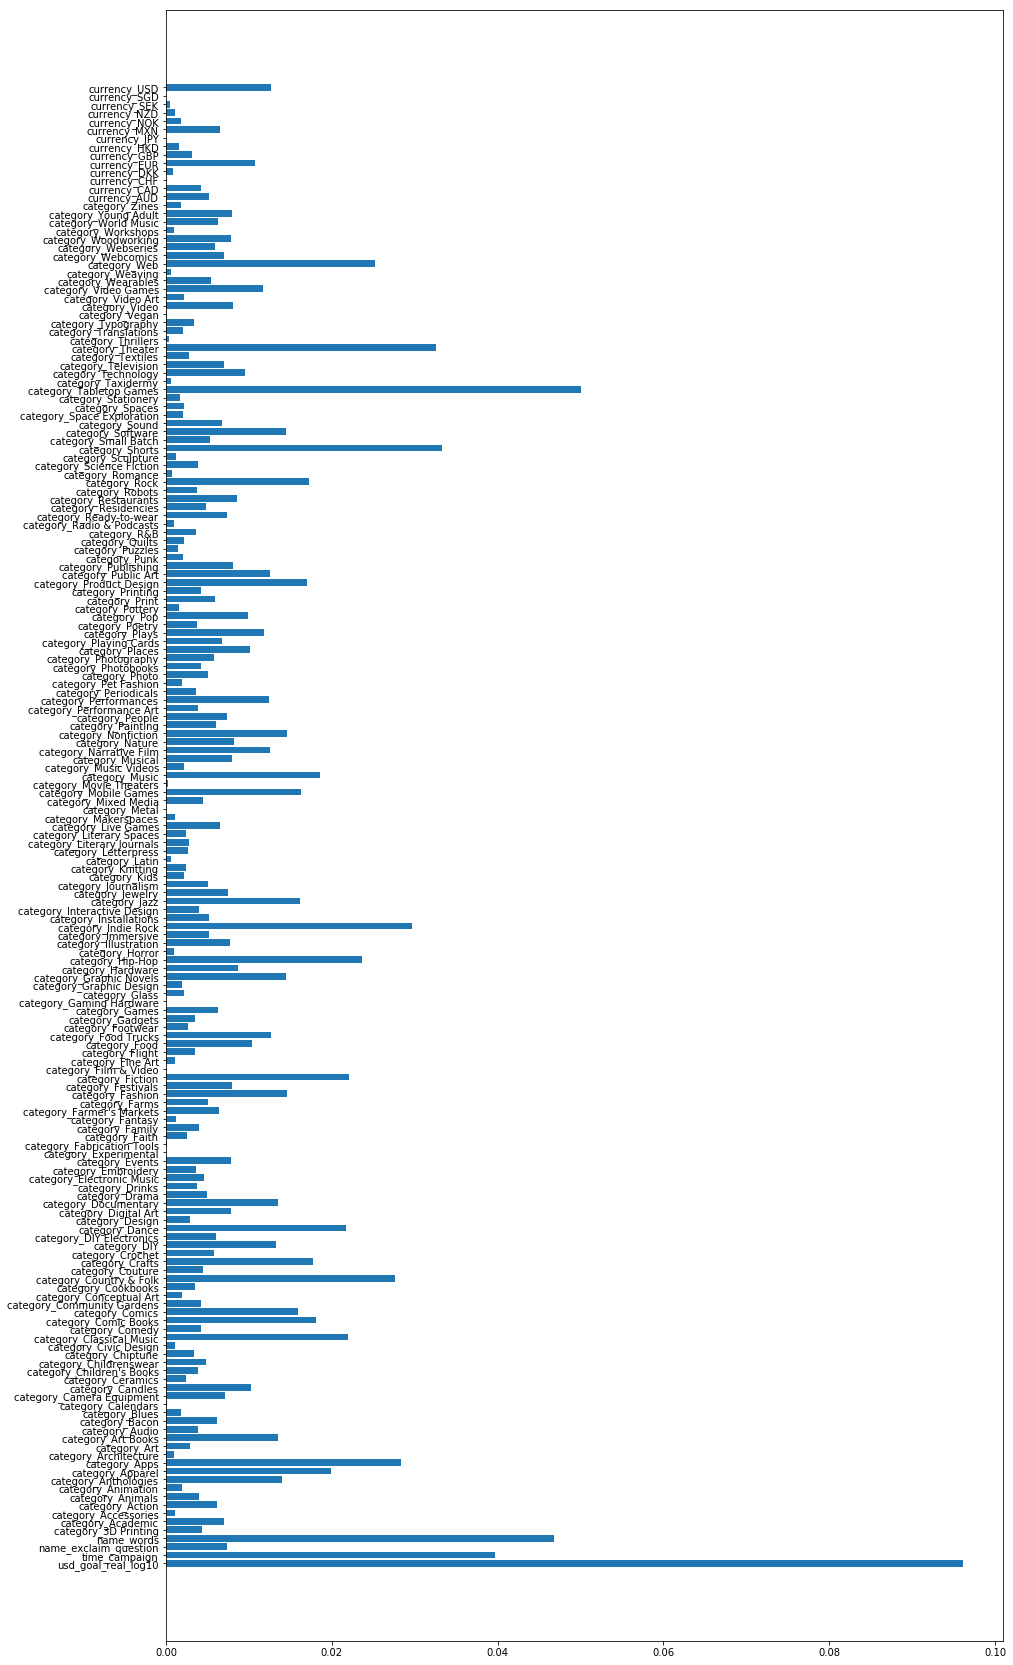

In [32]:
abs_coef = np.abs(sfm.estimator_.coef_)
plt.figure(figsize=(15, 30))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [33]:
df_TRAIN.drop(remove_feature, axis=1, inplace=True)
df_TEST.drop(remove_feature, axis=1, inplace=True)

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
display(df_TRAIN.describe())
display(df_TEST.describe())

,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,...,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000
mean,0.404571,3.726273,33.943299,0.078835,5.651624,0.001752,0.002382,0.008299,0.001881,0.000735,...,0.043627,0.088682,0.001477,0.000060,0.004229,0.001752,0.003806,0.004602,0.001338,0.787876
std,0.490810,0.723414,12.700887,0.269481,2.782060,0.041826,0.048746,0.090719,0.043325,0.027099,...,0.204264,0.284285,0.038408,0.007765,0.064890,0.041826,0.061579,0.067679,0.036553,0.408813
min,0.000000,0.004321,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,8.180114,92.000000,1.000000,41.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,state,usd_goal_real_log10,time_campaign,name_exclaim_question,name_words,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,...,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.00000,66335.000000,66335.000000,66335.000000
mean,0.401100,3.731848,34.001176,0.078842,5.667023,0.001553,0.002186,0.008110,0.001839,0.000513,...,0.042240,0.089621,0.001281,0.000106,0.004357,0.001794,0.00398,0.004357,0.001492,0.790774
std,0.490125,0.726398,12.762985,0.269494,2.795174,0.039374,0.046703,0.089692,0.042846,0.022634,...,0.201138,0.285640,0.035774,0.010272,0.065862,0.042317,0.06296,0.065862,0.038603,0.406759
min,0.000000,0.252853,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,3.301247,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,0.000000,3.699057,30.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,1.000000,4.176120,36.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
max,1.000000,8.221053,92.000000,1.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [35]:
n_explanatory_features = len(df_TRAIN.columns)-1
n_explanatory_features

173

In [36]:
y_train = df_TRAIN["state"].values
X_train = df_TRAIN.drop("state", axis=1).values
y_test = df_TEST["state"].values
X_test = df_TEST.drop("state", axis=1).values

# 3. Logistic Regression (Elastic Net)

In [37]:
%%time

# Make Pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', SGDClassifier(loss='log', penalty='elasticnet',  max_iter=100, fit_intercept=True, random_state=1234))])

# Hyper parameter for Grid search
alphas = np.logspace(-5, -1, 5, base=10)
l1_ratios = np.arange(0.0, 1.1, 0.1)

param_grid = {
    'clf__alpha' : alphas,
    'clf__l1_ratio' : l1_ratios
}

grid_search = GridSearchCV(pipe, param_grid , cv=5)
grid_search.fit(X_train, y_train)


print('best_params : {}'.format(grid_search.best_params_))
print('best_score : {}'.format(grid_search.best_score_))
print('test_score : {}'.format(grid_search.score(X_test, y_test)))

best_params : {'clf__alpha': 0.001, 'clf__l1_ratio': 0.0}
best_score : 0.6754051405743574
test_score : 0.6750885656139293
CPU times: user 2h 21min 29s, sys: 5min 19s, total: 2h 26min 48s
Wall time: 2h 24min 41s


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/ten

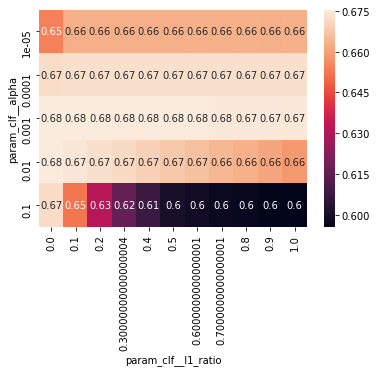

In [38]:
pvt = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
    values='mean_test_score', index='param_clf__alpha', columns='param_clf__l1_ratio')
ax = sns.heatmap(pvt, annot=True)

# 4. Decision Tree

In [39]:
%%time

# Hyper parameter for Grid search
max_depths = np.arange(5, 21)

param_grid = {
    'max_depth' : max_depths
}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion="entropy",  min_samples_split=3, min_samples_leaf=3, random_state=1234), param_grid , cv=5)
grid_search.fit(X_train, y_train)


print('best_params : {}'.format(grid_search.best_params_))
print('best_score : {}'.format(grid_search.best_score_))
print('test_score : {}'.format(grid_search.score(X_test, y_test)))

best_params : {'max_depth': 16}
best_score : 0.6557548805306399
test_score : 0.6589130926358634
CPU times: user 10min 12s, sys: 34.4 s, total: 10min 46s
Wall time: 10min 46s


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
No handles with labels found to put in legend.


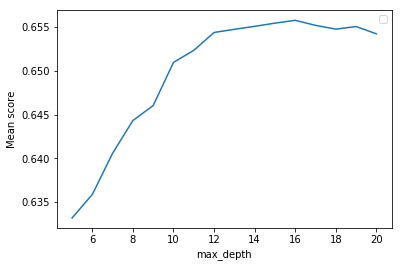

In [40]:
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores)

plt.plot(max_depths, scores)
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Mean score')
plt.show()

# 5. Random Forest

In [41]:
%%time

# Hyper parameter for Grid search
n_estimatorss = np.arange(5, 21)
max_depths = np.arange(5, 41)

param_grid = {
    'n_estimators' : n_estimatorss,
    'max_depth' : max_depths
}

grid_search = GridSearchCV(RandomForestClassifier(criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234), 
                           param_grid , cv=5)
grid_search.fit(X_train, y_train)


print('best_params : {}'.format(grid_search.best_params_))
print('best_score : {}'.format(grid_search.best_score_))
print('test_score : {}'.format(grid_search.score(X_test, y_test)))

best_params : {'max_depth': 35, 'n_estimators': 20}
best_score : 0.6789892213763473
test_score : 0.6784955151880606
CPU times: user 7h 44min 5s, sys: 21min 30s, total: 8h 5min 36s
Wall time: 8h 5min 41s


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/ten

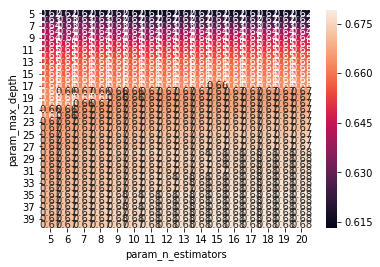

In [42]:
pvt = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
ax = sns.heatmap(pvt, annot=True)

# 6. AdaBoost

In [43]:
%%time

# Hyper parameter for Grid search
n_estimatorss = np.arange(5, 21)
max_depths = np.arange(5, 16)

param_grid = {
    'n_estimators' : n_estimatorss,
    'base_estimator__max_depth' : max_depths
}

grid_search = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="entropy"),
                                           random_state=1234), 
                           param_grid, cv=5)
grid_search.fit(X_train, y_train)


print('best_params : {}'.format(grid_search.best_params_))
print('best_score : {}'.format(grid_search.best_score_))
print('test_score : {}'.format(grid_search.score(X_test, y_test)))

best_params : {'base_estimator__max_depth': 7, 'n_estimators': 20}
best_score : 0.6832554458430693
test_score : 0.684028039496495
CPU times: user 19h 28min 42s, sys: 7min 22s, total: 19h 36min 4s
Wall time: 19h 38min 5s


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/ten

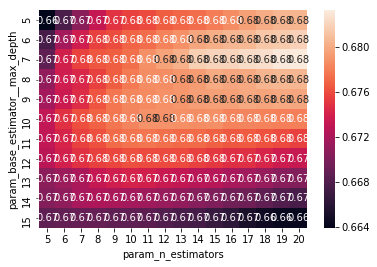

In [44]:
pvt = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
    values='mean_test_score', index='param_base_estimator__max_depth', columns='param_n_estimators')
ax = sns.heatmap(pvt, annot=True)

# 7. Neural Network

In [45]:
def kick_model(activation="relu", optimizer="adam", out_dim=100, hidden_layers=1):
    model = Sequential()
    model.add(Dense(out_dim, input_dim=n_explanatory_features, activation=activation))
    for i in range(hidden_layers):
        # Add one hidden layer
        model.add(Dense(out_dim, activation=activation))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [46]:
%%time
activation = ["relu"]
optimizer = ["adam"]
out_dim = np.arange(10, 110, 10)
nb_epoch = [25]
batch_size = [100]
hidden_layers = np.arange(1, 10)

# Make Pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('nn', KerasClassifier(build_fn=kick_model, verbose=0))])


param_grid = {
    'nn__activation' : activation,
    'nn__optimizer' : optimizer,
    'nn__out_dim' : out_dim,
    'nn__nb_epoch' : nb_epoch,
    'nn__batch_size' : batch_size,
    'nn__hidden_layers' : hidden_layers
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)


print('best_params : {}'.format(grid_search.best_params_))
print('best_score : {}'.format(grid_search.best_score_))
print('test_score : {}'.format(grid_search.score(X_test, y_test)))

best_params : {'nn__activation': 'relu', 'nn__batch_size': 100, 'nn__hidden_layers': 1, 'nn__nb_epoch': 25, 'nn__optimizer': 'adam', 'nn__out_dim': 100}
best_score : 0.677926435746972
test_score : 0.6794603182420021
CPU times: user 9h 48min, sys: 23min 47s, total: 10h 11min 48s
Wall time: 9h 25min 58s


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/ten

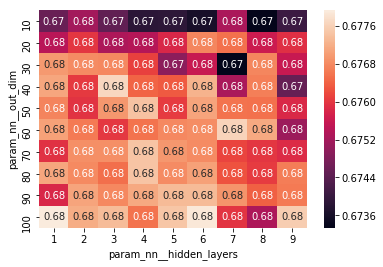

In [47]:
pvt = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
    values='mean_test_score', index='param_nn__out_dim', columns='param_nn__hidden_layers')
ax = sns.heatmap(pvt, annot=True)